# BL531 tender grating efficiency measurements
Xiaoya Chong, AW, SP, VV

4 June, 2024

In [ ]:
import epics
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import sleep as time_sleep
from tqdm import tqdm
import socket


## Define mono calibration and routine

In [ ]:
# --------------------------------------------------------------------------------------------------------------------------------------------------------------

# define mono angle to energy conversion

#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
#Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
#Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg

# inverse function to go from mono angle to eV
energy_eV = lambda mono_deg_input: (h_m2kgps*c_mps*e_eV)/((2 * a_Si111_m) * np.sin((np.pi/180)*(mono_deg_input - mono_offset_deg)))



## Define connection to rotary stage

In [ ]:
# settings: the host and port of the Windows PC
host = '131.243.80.251'  # Standard loopback interface address         
port = 6000        # Port to listen on (non-privileged ports are > 1023)

# send a message (tpye: bytes) to the Windows PC 
def apt_send(msg_str):
    # connect to the server
    client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client.connect((host, port))

    # recieve a message from the server to see if the connection is successful
    msg_from_server = client.recv(4096)
    print (msg_from_server)

    # send the message to the server
    client.send(msg_str)

    msg_from_server2 = client.recv(4096)
    print(msg_from_server2)

    # close the connection
    client.close()
    return msg_from_server2


# transfer the position value from int to bytes and call apt_send() 
def apt_move(position_au):
    msg_str = str(position_au).encode("utf-8")
    apt_send(msg_str)

# send "close" to the Windows PC to close the server
def apt_stop():
    apt_send(b"close")

In [ ]:
# define the postion value, call apt_move() to send the message to the server
position_au = 0
apt_move(position_au)

b'Server Message 1: Recieved the position request from the client ...'
b'Server Message 2: The position is set to 0'


In [ ]:
# close the server

#ARE YOU SURE???????
apt_stop()

## Move the monochromator with EPICS

In [ ]:
# set the mono angle
epics.caput('bl531_xps1:mono_angle_deg', mono_deg(8000))

time_sleep(2)

# print mono angle for reference
epics.caget('bl531_xps1:mono_angle_deg')


27.097538443499513

## Save and read a Pilatus image

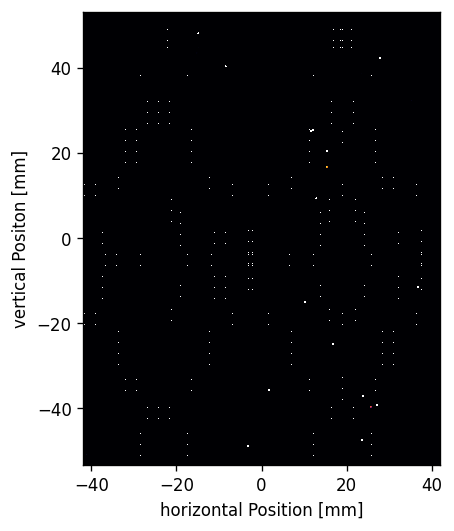

In [ ]:
filepath = '/mnt/data531/WAXS531_016.tif'


# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
#im_np[np.where(im_np>100000.0)] =0

dx_m = 172e-6
Nx_px = 487
Ny_px = 619
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

#mask = im_np > np.max(im_np)
#im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno', norm=LogNorm())
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

## Energy scan

In [ ]:
# # saxs energy scan

# Es_eV = np.linspace(6000, 10000, 9)        # same energy range/resolution as nexafs


# epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
# time_sleep(5)
# filenames = ()
# for i_e in tqdm(range(len(Es_eV))):
#     mono_angle_deg = mono_deg(Es_eV[i_e])
    
#     epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
#     time_sleep(5)


#     aqtime_s = 2
#     # epics.caput('13PIL1:cam1:AcquireTime', 1)
#     #epics.caput('13PIL1:cam1:AcquirePeriod', 1)
#     #epics.caput('13PIL1:cam1:Acquire',1)
#     time_sleep(5)

#     # last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
#     # last_filename = bytes(last_filename_ascii).decode()
#     # filenames += (last_filename,)

100%|██████████| 9/9 [01:03<00:00,  7.01s/it]


In [ ]:
## Energy scan nested into angle scan

# ga_deg = np.linspace(87, 88.5, 31  )#        grazing angles
# Es_eV = np.linspace(6000, 10000, 9)        # same energy range/resolution as nexafs


# filenames = ()
# for i_g in range(len(ga_deg)):
#     position_au = ga_deg[i_g]
#     apt_move(position_au)
#     time_sleep(2)
#     #break
#     epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
#     time_sleep(5)
#     for i_e in range(len(Es_eV)): 
        
#         mono_angle_deg = mono_deg(Es_eV[i_e])        
#         epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
#         time_sleep(10)

#         series_nb = "%03.0f" % (i_g+1)
#         image_nb = "%03.0f"  % (i_e+1)

#         current_filename = "20240604_tender_grating_" + series_nb + "_" +image_nb
#         epics.caput('13PIL1:cam1:FileName',current_filename)
#         epics.caput('13PIL1:cam1:Acquire',1)

b'Server Message 1: Recieved the position request from the client ...'
b'Server Message 2: The position is set to 87.0'
b'Server Message 1: Recieved the position request from the client ...'
b'Server Message 2: The position is set to 87.05'
b'Server Message 1: Recieved the position request from the client ...'
b'Server Message 2: The position is set to 87.1'
b'Server Message 1: Recieved the position request from the client ...'
b'Server Message 2: The position is set to 87.15'
b'Server Message 1: Recieved the position request from the client ...'
b'Server Message 2: The position is set to 87.2'
b'Server Message 1: Recieved the position request from the client ...'
b'Server Message 2: The position is set to 87.25'
b'Server Message 1: Recieved the position request from the client ...'
b'Server Message 2: The position is set to 87.3'
b'Server Message 1: Recieved the position request from the client ...'
b'Server Message 2: The position is set to 87.35'
b'Server Message 1: Recieved the pos

## Angle and energy scan

In [ ]:
## Energy scan nested into angle scan

ga_deg = np.linspace(87, 88.5, 61)#        grazing angles
Es_eV = np.linspace(6000, 10000, 9)        # same energy range/resolution as nexafs


filenames = ()
for i_g in range(len(ga_deg)):
    position_au = ga_deg[i_g]
    apt_move(position_au)
    epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
    time_sleep(5)
    for i_e in range(len(Es_eV)): 
        
        mono_angle_deg = mono_deg(Es_eV[i_e])        
        epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
        time_sleep(5)

        series_nb = "%03.0f" % (i_g+1)
        image_nb = "%03.0f"  % (i_e+1)

        current_filename = "20240606e_tender_grating_" + series_nb + "_" +image_nb
        epics.caput('13PIL1:cam1:FileName',current_filename)
        epics.caput('13PIL1:cam1:Acquire',1)
        time_sleep(5)

b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.0'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.025'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.05'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.075'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.1'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.125'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.15'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server 

## reference energy scan

In [124]:
# reference energy scan
Es_eV = np.linspace(6000, 10000, 9)        # same energy range/resolution as nexafs


filenames = ()
epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
time_sleep(5)
for i_e in range(len(Es_eV)): 
    
    mono_angle_deg = mono_deg(Es_eV[i_e])        
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    time_sleep(10)

    series_nb = "%03.0f" % 0
    image_nb = "%03.0f"  % (i_e+1)

    current_filename = "20240606e_tender_grating_" + series_nb + "_" +image_nb
    epics.caput('13PIL1:cam1:FileName',current_filename)
    epics.caput('13PIL1:cam1:Acquire',1)

## Fine angle scan at fixed energy

In [111]:
## Fine angle scan

ga_deg = np.linspace(87, 88.5, 151)#        grazing angles
Es_eV = np.linspace(8000,8000,1)      # same energy range/resolution as nexafs


filenames = ()
for i_g in range(len(ga_deg)):
    position_au = ga_deg[i_g]
    apt_move(position_au)
    #break
    epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
    time_sleep(5)
    for i_e in range(len(Es_eV)): 
        
        mono_angle_deg = mono_deg(Es_eV[i_e])        
        epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
        time_sleep(5)

        series_nb = "%03.0f" % (i_g+1)
        image_nb = "%03.0f"  % (i_e+1)

        current_filename = "20240606d_tender_grating_" + series_nb + "_" +image_nb
        epics.caput('13PIL1:cam1:FileName',current_filename)
        epics.caput('13PIL1:cam1:Acquire',1)
        time_sleep(5)

b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.0'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.01'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.02'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.03'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.04'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.05'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.06'
b'Server Message 1: Recieved the position request successfully from the client'
b'Server Me

### Collect a single image (000-000)

In [123]:
#sample
series_nb = "%03.0f" % 0
image_nb = "%03.0f"  % 0
current_filename = "20240606e_tender_grating_" + series_nb + "_" +image_nb
epics.caput('13PIL1:cam1:FileName',current_filename)
epics.caput('13PIL1:cam1:Acquire',1)

1

## Changing some beamline settings manually

### Change sample slit position

In [29]:
# 1 enable motor
epics.caput('DMC02:E.CNEN', 1)
#E- Outboard slit


1

In [30]:
# 2- read motor position
epics.caget('DMC02:E', 1)

-25.0

In [33]:
# 3- change slit position
epics.caput('DMC02:E', -28) #was -25 initially

1

### Change camera exposure time

In [64]:
epics.caput('13PIL1:cam1:AcquireTime', 1)
epics.caput('13PIL1:cam1:AcquirePeriod', 1)

1

### Move rotary stage

In [113]:
apt_move(87.5)

b'Server Message 1: Recieved the position request successfully from the client'
b'Server Message 2: The position is set to 87.5'


### Change mono energy

In [122]:
# change mon energy
epics.caput('bl531_xps1:mono_angle_deg',mono_deg(8000))

1

In [108]:
# readout mono angle
epics.caget('bl531_xps1:mono_angle_deg')

27.097538443499513

In [117]:
# disconnect motor server
apt_stop()

KeyboardInterrupt: 